In [1]:
import tensorflow as tf
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model


2025-04-27 12:39:47.798791: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Load CSV
df = pd.read_csv("../data/metadata.csv")

# Pick one image to test
img_path = df.loc[3520, 'filepath']
true_label = df.loc[3520, 'label']


def generate_gradcam_keras(model, img_array, target_layer_name, class_index=None):
    # Get the model's prediction
    preds = model.predict(img_array)
    pred_index = np.argmax(preds[0]) if class_index is None else class_index

    # Get the output of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(target_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, pred_index]

    # Compute gradients of the top predicted class
    grads = tape.gradient(loss, conv_outputs)

    # Pool the gradients over all spatial locations
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each feature map by its gradient importance
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/rds/general/user/ft824/home/anaconda3/envs/breakhis/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


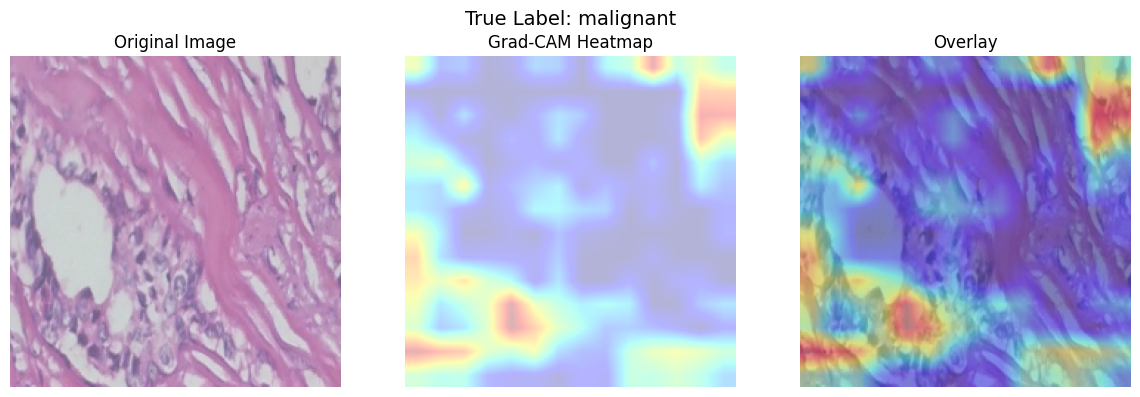

In [3]:

# --- Load and preprocess image ---
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Keep a version for display
img_display = cv2.imread(img_path)
img_display = cv2.resize(img_display, (224, 224))

# --- Load model ---
model = load_model("/rds/general/user/ft824/home/ML_BreakHis/scr/resnet50_output/resnet50_HPO_output/models_train4/train4_job9_bs16_lr0.0001_adam_wd0.0001.h5")

# --- Choose last conv layer for Grad-CAM ---
last_conv_layer = "conv4_block6_out"  # ResNet50 specific

# --- Generate Grad-CAM ---
heatmap = generate_gradcam_keras(model, img_array, last_conv_layer)

# --- Resize heatmap and create overlay ---
heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
overlay = heatmap_colored * 0.4 + img_display

# --- Plotting side-by-side ---
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Original
ax[0].imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[0].axis('off')

# Heatmap only
ax[1].imshow(heatmap_resized, cmap='jet', alpha =0.3)
ax[1].set_title("Grad-CAM Heatmap")
ax[1].axis('off')

# Overlay
ax[2].imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
ax[2].imshow(heatmap_resized, cmap='jet', alpha =0.4)
ax[2].set_title("Overlay")
ax[2].axis('off')

# Optional: Add a super title
fig.suptitle(f"True Label: {true_label}", fontsize=14)
plt.tight_layout()
plt.show()




In [18]:
img_path = df.loc[2, 'filepath']
true_label = df.loc[2, 'label']



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


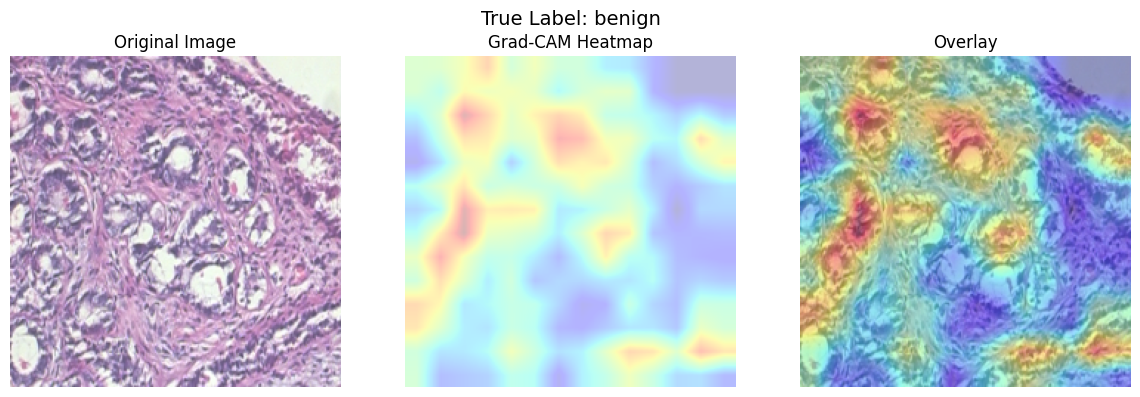

In [19]:

# --- Load and preprocess image ---
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Keep a version for display
img_display = cv2.imread(img_path)
img_display = cv2.resize(img_display, (224, 224))

# --- Load model ---
model = load_model("/rds/general/user/ft824/home/ML_BreakHis/scr/resnet50_output/resnet50_HPO_output/models_train4/train4_job9_bs16_lr0.0001_adam_wd0.0001.h5")

# --- Choose last conv layer for Grad-CAM ---
last_conv_layer = "conv4_block6_out"  # ResNet50 specific

# --- Generate Grad-CAM ---
heatmap = generate_gradcam_keras(model, img_array, last_conv_layer)

# --- Resize heatmap and create overlay ---
heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
overlay = heatmap_colored * 0.4 + img_display

# --- Plotting side-by-side ---
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Original
ax[0].imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[0].axis('off')

# Heatmap only
ax[1].imshow(heatmap_resized, cmap='jet', alpha =0.3)
ax[1].set_title("Grad-CAM Heatmap")
ax[1].axis('off')

# Overlay
ax[2].imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
ax[2].imshow(heatmap_resized, cmap='jet', alpha =0.4)
ax[2].set_title("Overlay")
ax[2].axis('off')

# Optional: Add a super title
fig.suptitle(f"True Label: {true_label}", fontsize=14)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


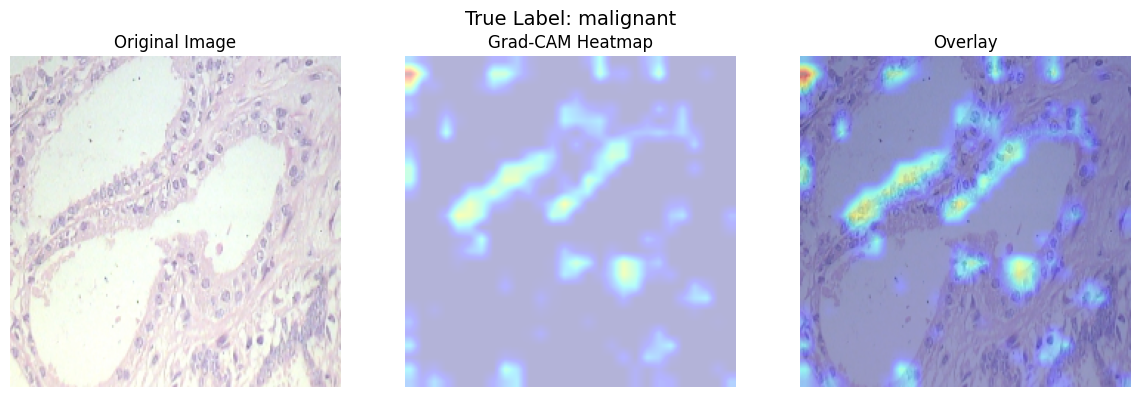

In [13]:



# --- Load and preprocess image ---
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Keep a version for display
img_display = cv2.imread(img_path)
img_display = cv2.resize(img_display, (224, 224))

# --- Load model ---
model = load_model("/rds/general/user/ft824/home/ML_BreakHis/scr/resnet50_output/resnet50_HPO_output/models_train4/train4_job9_bs16_lr0.0001_adam_wd0.0001.h5")

# --- Choose last conv layer for Grad-CAM ---
last_conv_layer = "conv3_block4_out"  # ResNet50 specific

# --- Generate Grad-CAM ---
heatmap = generate_gradcam_keras(model, img_array, last_conv_layer)

# --- Resize heatmap and create overlay ---
heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
overlay = heatmap_colored * 0.4 + img_display

# --- Plotting side-by-side ---
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Original
ax[0].imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[0].axis('off')

# Heatmap only
ax[1].imshow(heatmap_resized, cmap='jet', alpha =0.3)
ax[1].set_title("Grad-CAM Heatmap")
ax[1].axis('off')

# Overlay
ax[2].imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
ax[2].imshow(heatmap_resized, cmap='jet', alpha =0.4)
ax[2].set_title("Overlay")
ax[2].axis('off')

# Optional: Add a super title
fig.suptitle(f"True Label: {true_label}", fontsize=14)
plt.tight_layout()
plt.show()




1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


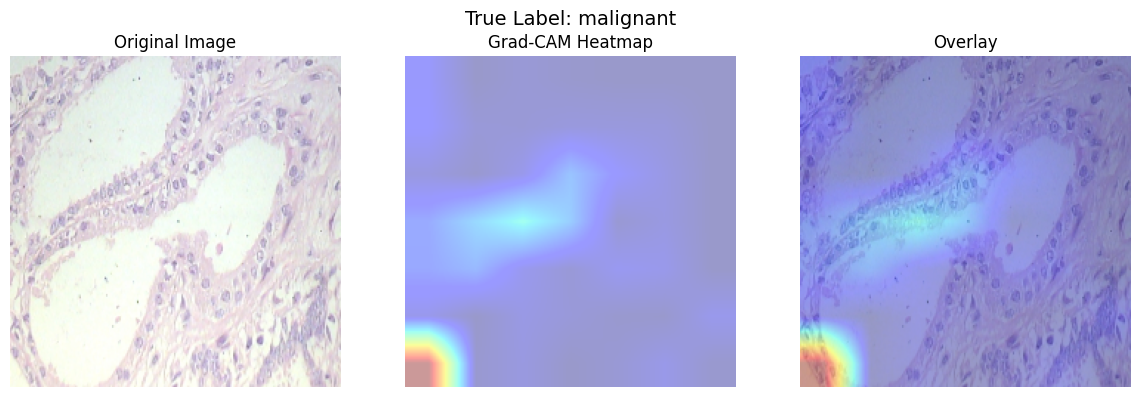

In [14]:
# --- Load and preprocess image ---
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Keep a version for display
img_display = cv2.imread(img_path)
img_display = cv2.resize(img_display, (224, 224))

# --- Load model ---
model = load_model("/rds/general/user/ft824/home/ML_BreakHis/scr/resnet50_output/resnet50_HPO_output/models_train4/train4_job9_bs16_lr0.0001_adam_wd0.0001.h5")

# --- Choose last conv layer for Grad-CAM ---
last_conv_layer = "conv5_block3_out"  # ResNet50 specific

# --- Generate Grad-CAM ---
heatmap = generate_gradcam_keras(model, img_array, last_conv_layer)

# --- Resize heatmap and create overlay ---
heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
overlay = heatmap_colored * 0.4 + img_display

# --- Plotting side-by-side ---
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Original
ax[0].imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[0].axis('off')

# Heatmap only
ax[1].imshow(heatmap_resized, cmap='jet', alpha =0.4)
ax[1].set_title("Grad-CAM Heatmap")
ax[1].axis('off')

# Overlay
ax[2].imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
ax[2].imshow(heatmap_resized, cmap='jet', alpha =0.4)
ax[2].set_title("Overlay")
ax[2].axis('off')

# Optional: Add a super title
fig.suptitle(f"True Label: {true_label}", fontsize=14)
plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


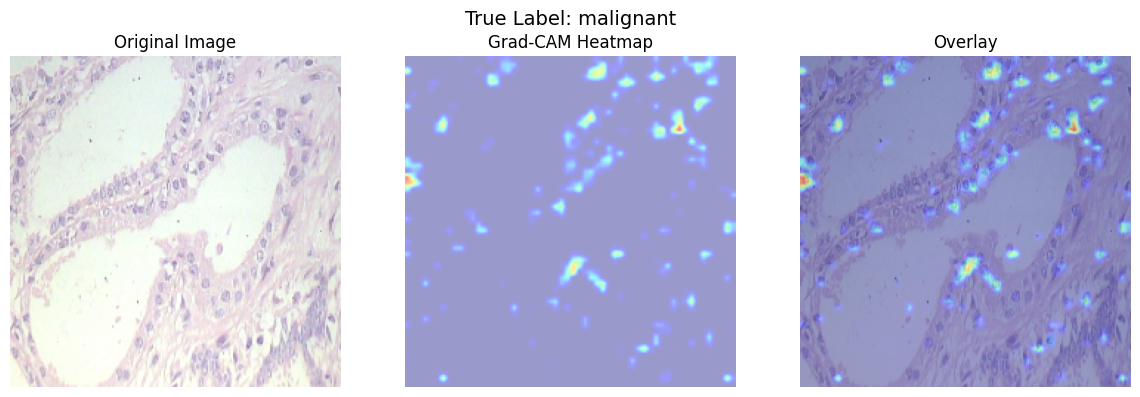

In [15]:

# --- Load and preprocess image ---
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Keep a version for display
img_display = cv2.imread(img_path)
img_display = cv2.resize(img_display, (224, 224))

# --- Load model ---
model = load_model("/rds/general/user/ft824/home/ML_BreakHis/scr/resnet50_output/resnet50_HPO_output/models_train4/train4_job9_bs16_lr0.0001_adam_wd0.0001.h5")

# --- Choose last conv layer for Grad-CAM ---
last_conv_layer = "conv2_block3_out"  # ResNet50 specific

# --- Generate Grad-CAM ---
heatmap = generate_gradcam_keras(model, img_array, last_conv_layer)

# --- Resize heatmap and create overlay ---
heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
overlay = heatmap_colored * 0.4 + img_display

# --- Plotting side-by-side ---
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Original
ax[0].imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[0].axis('off')

# Heatmap only
ax[1].imshow(heatmap_resized, cmap='jet', alpha =0.4)
ax[1].set_title("Grad-CAM Heatmap")
ax[1].axis('off')

# Overlay
ax[2].imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
ax[2].imshow(heatmap_resized, cmap='jet', alpha =0.4)
ax[2].set_title("Overlay")
ax[2].axis('off')

# Optional: Add a super title
fig.suptitle(f"True Label: {true_label}", fontsize=14)
plt.tight_layout()
plt.show()

